# U-Net sanity check and Sentinel-2 inference

This notebook:
1) loads the saved U-Net model,
2) runs inference on one training sample and visualizes results,
3) downloads a Sentinel-2 L2A COG tile over Egypt via STAC (AWS public),
   preprocesses it to match the AgriFieldNet pipeline, runs the model, and visualizes results.

## 0. Setup

In [1]:
from __future__ import annotations

import json
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import requests
import pystac_client
import planetary_computer
import torch
from matplotlib.colors import ListedColormap
from rasterio import windows
from rasterio.enums import Resampling
from rasterio.warp import reproject, transform

from agrovision_core.models.unet_baseline import UNet

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Inspect dataset artifacts (normalization, classes, shapes)

In [2]:
repo_root = Path.cwd().parent

data_dir = repo_root / "data" / "processed"
norm_path = data_dir / "normalization_stats.json"
class_map_path = data_dir / "class_map.json"

with norm_path.open("r", encoding="utf-8") as f:
    norm_stats = json.load(f)

with class_map_path.open("r", encoding="utf-8") as f:
    class_map = json.load(f)

bands = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B09",
    "B11",
    "B12",
]
bands

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12']

In [3]:
train_images_path = data_dir / "train_images.npy"
train_masks_path = data_dir / "train_masks.npy"

train_images = np.load(train_images_path, mmap_mode="r")
train_masks = np.load(train_masks_path, mmap_mode="r")

print("train_images shape:", train_images.shape, train_images.dtype)
print("train_masks shape:", train_masks.shape, train_masks.dtype)

sample_idx = 0
sample_img = train_images[sample_idx]
sample_mask = train_masks[sample_idx]

print("sample image shape:", sample_img.shape)
print("sample image min/max:", float(sample_img.min()), float(sample_img.max()))
print("sample mask shape:", sample_mask.shape)
print("sample mask unique (first 20):", np.unique(sample_mask)[:20])

train_images shape: (932, 12, 256, 256) float32
train_masks shape: (932, 256, 256) int64
sample image shape: (12, 256, 256)
sample image min/max: -4.2578325271606445 3.655348777770996
sample mask shape: (256, 256)
sample mask unique (first 20): [0 1 2]


## 2. Load model and run on one training sample

In [4]:
model_path = repo_root / "outputs" / "models" / "unet_baseline_best_model.pth"
num_classes = int(class_map.get("num_classes", 14))

checkpoint = torch.load(model_path, map_location="cpu")
state_dict = checkpoint.get("model_state", checkpoint)
ckpt_in_channels = checkpoint.get("in_channels", 12)
ckpt_num_classes = checkpoint.get("num_classes", num_classes)

model = UNet(in_channels=ckpt_in_channels, num_classes=ckpt_num_classes)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

x = torch.from_numpy(sample_img.copy()).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(x)
    probs = torch.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()

print("logits shape:", logits.shape)
print("pred shape:", pred.shape)


logits shape: torch.Size([1, 14, 256, 256])
pred shape: (256, 256)


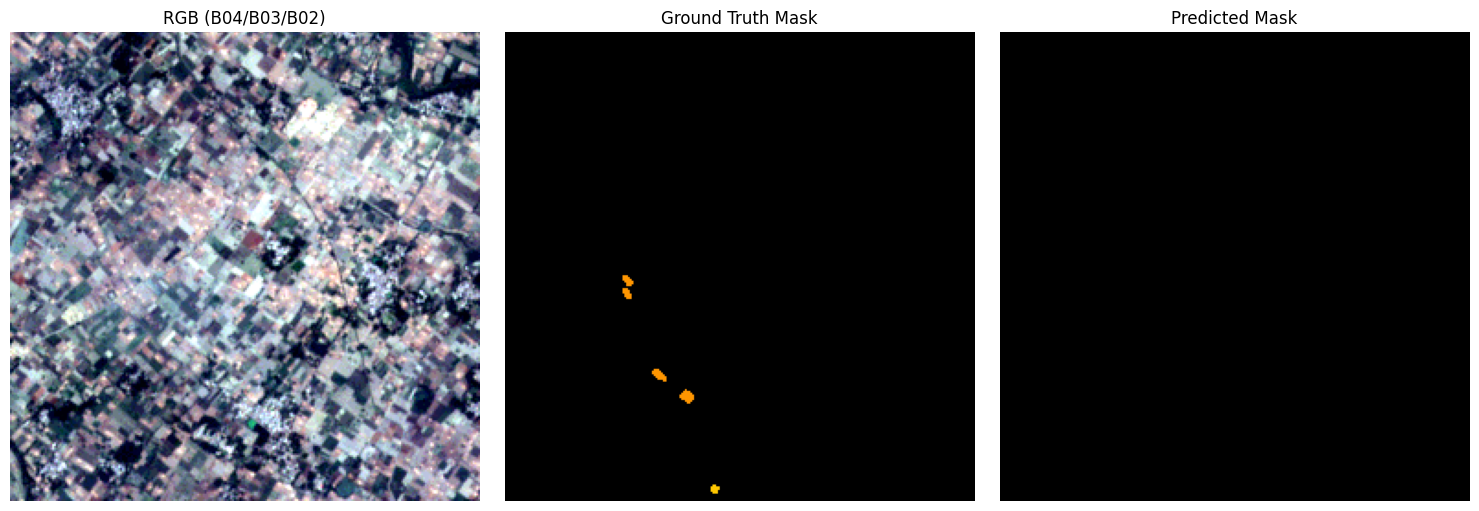

In [5]:
def build_colormap(class_map_obj: dict) -> ListedColormap:
    colors = []
    classes = class_map_obj.get("classes", {})
    contig_to_raw = class_map_obj.get("contig_to_raw", {})
    num_classes = int(class_map_obj.get("num_classes", len(classes)))
    for idx in range(num_classes):
        raw_id = str(contig_to_raw.get(str(idx), idx))
        color = classes[raw_id]["color"]
        colors.append([c / 255.0 for c in color])
    return ListedColormap(colors)


cmap = build_colormap(class_map)

# RGB composite from normalized sample. Note: values are normalized.
rgb = np.stack([sample_img[3], sample_img[2], sample_img[1]], axis=-1)
rgb_min = np.percentile(rgb, 2)
rgb_max = np.percentile(rgb, 98)
rgb_vis = np.clip((rgb - rgb_min) / (rgb_max - rgb_min + 1e-6), 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rgb_vis)
axes[0].set_title("RGB (B04/B03/B02)")
axes[0].axis("off")

axes[1].imshow(sample_mask, cmap=cmap, vmin=0, vmax=num_classes - 1)
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes - 1)
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.tight_layout()
fig


### Class probability maps

Each plot is a *confidence heatmap* for one class.
- Brighter pixels = the model is more confident that pixel belongs to that class.
- Darker pixels = lower confidence.

Use these to see *where* the model thinks a class is present and *how strongly* it believes that.
Change `selected_classes` in the next cell to visualize different classes.

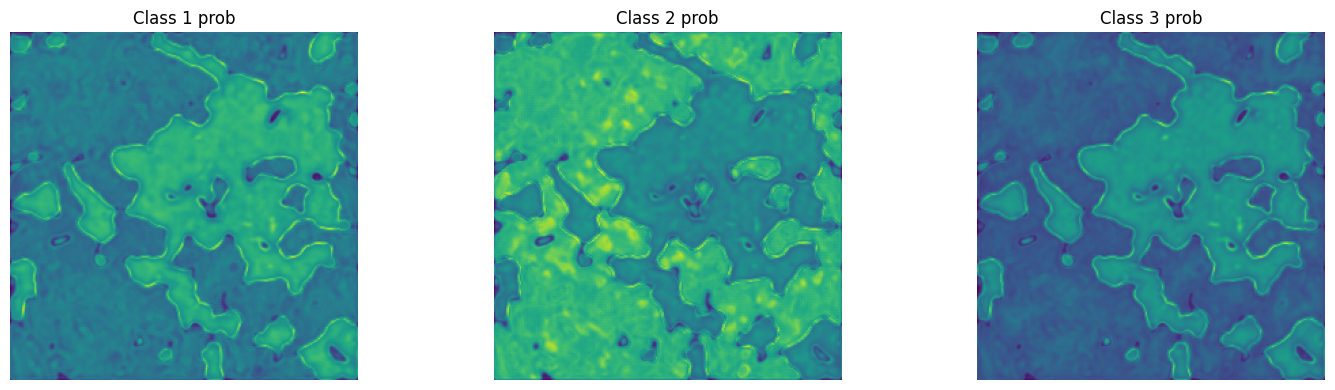

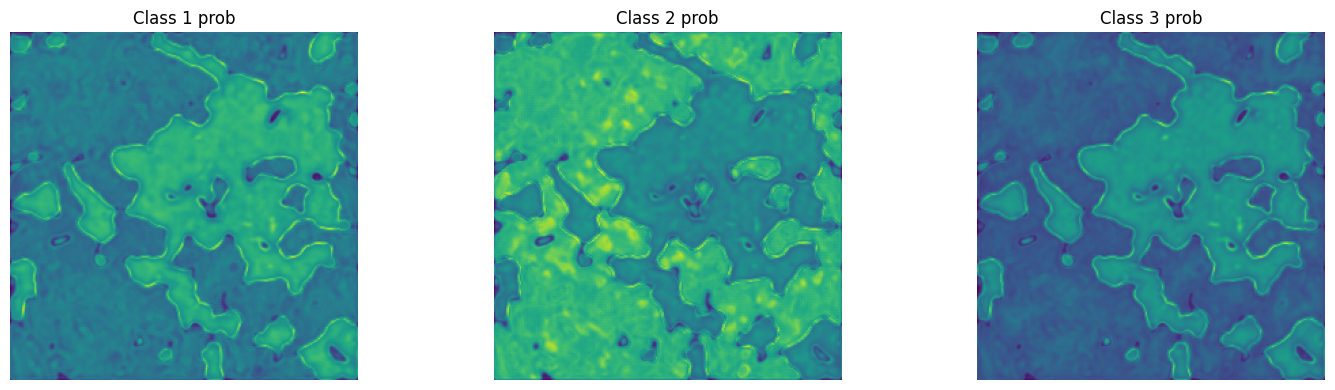

In [6]:
# Probability maps for a few classes
# Probability maps for a few classes
# Adjust these IDs based on your class_map if needed.
selected_classes = [1, 2, 3]
# One panel per class for quick comparison.
fig, axes = plt.subplots(1, len(selected_classes), figsize=(5 * len(selected_classes), 4))
if len(selected_classes) == 1:
    axes = [axes]
# Visualize the probability for each class channel.
for ax, cls_id in zip(axes, selected_classes):
    ax.imshow(probs[0, cls_id].cpu().numpy(), cmap="viridis")
    ax.set_title(f"Class {cls_id} prob")
    ax.axis("off")
plt.tight_layout()
fig

## 3. Sentinel-2 L2A (Egypt) via STAC (AWS public)

This section:
- samples one coordinate inside an Egypt bounding box,
- searches the STAC API for Sentinel-2 L2A COGs,
- downloads one 256x256 window, resampled to 10m,
- applies the same normalization, then runs the model.

In [7]:
STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
COLLECTION = "sentinel-2-l2a"

# Rough Egypt bounding box (lon_min, lat_min, lon_max, lat_max)
EGYPT_BBOX = (24.7, 21.7, 36.9, 31.7)


In [9]:
# Search a short date window (adjust as needed)
import pystac_client
import planetary_computer
def random_point_in_bbox(bbox):
    lon_min, lat_min, lon_max, lat_max = bbox
    lon = random.uniform(lon_min, lon_max)
    lat = random.uniform(lat_min, lat_max)
    return lat, lon

date_window = "2023-01-01/2024-12-31"
cloud_filter = 60
bbox_delta = 0.02  # degrees (~2 km)
max_tries = 6

catalog = pystac_client.Client.open(
    STAC_URL,
    modifier=planetary_computer.sign_inplace,
)

items = []
for _ in range(max_tries):
    if items:
        break
    lat, lon = random_point_in_bbox(EGYPT_BBOX)
    bbox = [lon - bbox_delta, lat - bbox_delta, lon + bbox_delta, lat + bbox_delta]
    search = catalog.search(
        collections=[COLLECTION],
        bbox=bbox,
        datetime=date_window,
        query={"eo:cloud_cover": {"lt": cloud_filter}},
        max_items=10,
    )
    items = list(search.items())

if not items:
    raise RuntimeError("No Sentinel-2 items found for sampled points/date. Try changing date/bbox.")

# Pick the scene with minimum cloud cover
items_sorted = sorted(items, key=lambda x: x.properties.get("eo:cloud_cover", 100))
item = items_sorted[0]
item.id, item.properties.get("eo:cloud_cover")


('S2B_MSIL2A_20241205T082229_R121_T36RWR_20241205T093809', 0.045103)

In [11]:
def get_asset_href(stac_item, band_name: str) -> str:
    assets = stac_item.assets
    if band_name not in assets:
        raise KeyError(f"Band {band_name} not in STAC item assets")
    return assets[band_name].href


band_hrefs = {b: get_asset_href(item, b) for b in bands}
list(band_hrefs.keys())[:3]


['B01', 'B02', 'B03']

In [12]:
import rasterio


def get_reference_window(href: str, center_lat: float, center_lon: float, size: int = 256):
    with rasterio.open(href) as src:
        # Convert lat/lon to dataset CRS
        x, y = transform("EPSG:4326", src.crs, [center_lon], [center_lat])
        row, col = src.index(x[0], y[0])
        half = size // 2
        row_off = max(0, row - half)
        col_off = max(0, col - half)
        row_off = min(row_off, src.height - size)
        col_off = min(col_off, src.width - size)
        win = windows.Window(col_off=col_off, row_off=row_off, width=size, height=size)
        return win, src.crs, src.transform


ref_href = band_hrefs["B02"]  # 10m band
ref_window, ref_crs, ref_transform = get_reference_window(ref_href, lat, lon, size=256)
ref_window

Window(col_off=4396, row_off=9744, width=256, height=256)

In [15]:
def read_and_resample_to_ref(href: str, ref_crs, ref_transform, ref_window, out_shape=(256, 256)):
    with rasterio.open(href) as src:
        # Compute bounds for target window in reference CRS
        ref_bounds = windows.bounds(ref_window, ref_transform)

        # Compute window in source dataset
        src_window = windows.from_bounds(*ref_bounds, transform=src.transform)
        src_window = src_window.round_offsets().round_lengths()

        src_data = src.read(1, window=src_window).astype(np.float32)
        src_transform = src.window_transform(src_window)

        dst = np.zeros(out_shape, dtype=np.float32)
        reproject(
            source=src_data,
            destination=dst,
            src_transform=src_transform,
            src_crs=src.crs,
            dst_transform=windows.transform(ref_window, ref_transform),
            dst_crs=ref_crs,
            resampling=Resampling.bilinear,
        )
        return dst


stack = []
for band in bands:
    band_arr = read_and_resample_to_ref(band_hrefs[band], ref_crs, ref_transform, ref_window)
    stack.append(band_arr)

s2_tile = np.stack(stack, axis=0)
s2_tile.shape

(12, 256, 256)

In [16]:
# Sentinel-2 COGs are scaled reflectance (often 0-10000).
# The training stats are small (~40-70), so scale by 0.01 by default.
S2_SCALE = 0.01
s2_tile = s2_tile * S2_SCALE

def normalize_tile(tile: np.ndarray, stats: dict, band_order: list[str]) -> np.ndarray:
    out = np.zeros_like(tile, dtype=np.float32)
    for i, band in enumerate(band_order):
        mean = stats[band]["mean"]
        std = stats[band]["std"]
        out[i] = (tile[i] - mean) / (std + 1e-6)
    return out


s2_norm = normalize_tile(s2_tile, norm_stats, bands)
print("s2_norm shape:", s2_norm.shape)
print("s2_norm min/max:", float(s2_norm.min()), float(s2_norm.max()))

s2_norm shape: (12, 256, 256)
s2_norm min/max: -14.019048690795898 12.497479438781738


## 4. Run model on Sentinel-2 tile and visualize

In [17]:
x_s2 = torch.from_numpy(s2_norm).unsqueeze(0).to(device)
assert x_s2.shape == (1, 12, 256, 256)

with torch.no_grad():
    logits_s2 = model(x_s2)
    probs_s2 = torch.softmax(logits_s2, dim=1)
    pred_s2 = torch.argmax(probs_s2, dim=1).squeeze(0).cpu().numpy()

print("pred_s2 shape:", pred_s2.shape)

pred_s2 shape: (256, 256)


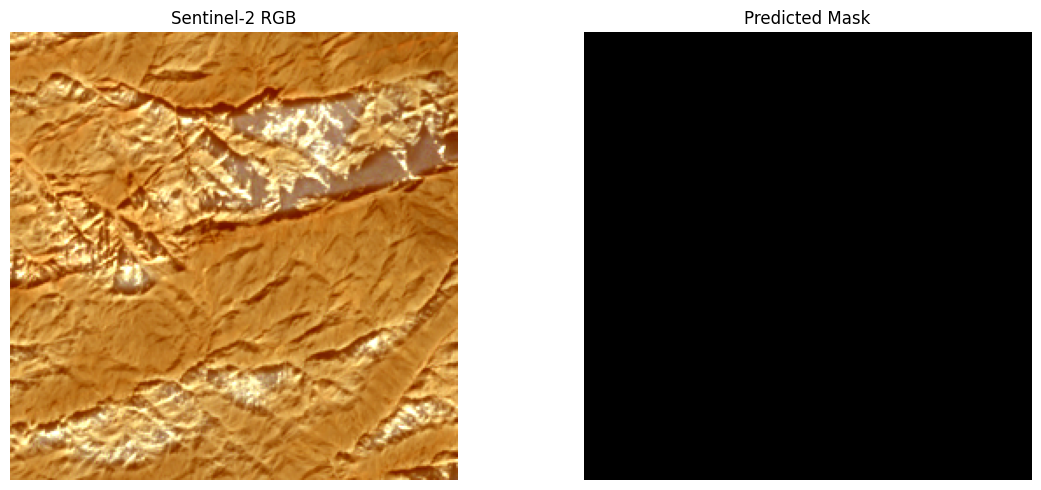

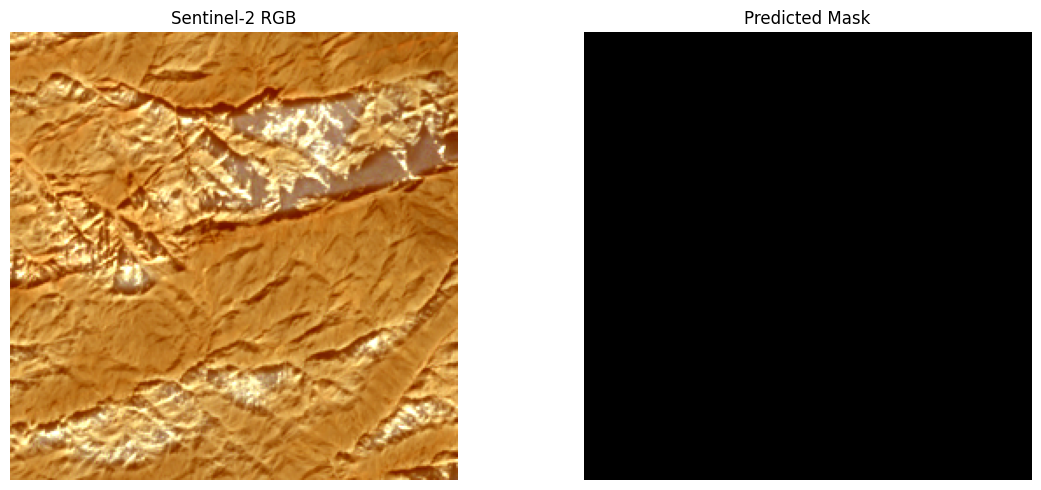

In [18]:
rgb_s2 = np.stack([s2_norm[3], s2_norm[2], s2_norm[1]], axis=-1)
rgb_min = np.percentile(rgb_s2, 2)
rgb_max = np.percentile(rgb_s2, 98)
rgb_vis_s2 = np.clip((rgb_s2 - rgb_min) / (rgb_max - rgb_min + 1e-6), 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(rgb_vis_s2)
axes[0].set_title("Sentinel-2 RGB")
axes[0].axis("off")

axes[1].imshow(pred_s2, cmap=cmap, vmin=0, vmax=num_classes - 1)
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

plt.tight_layout()
fig

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

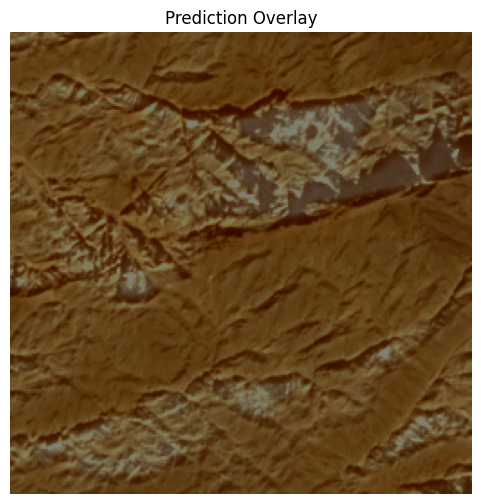

In [19]:
# Overlay prediction on RGB
overlay = rgb_vis_s2.copy()
pred_rgb = cmap(pred_s2)[:, :, :3]
alpha = 0.5
overlay = (1 - alpha) * overlay + alpha * pred_rgb

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("Prediction Overlay")
plt.axis("off")

## Results and notes

- If Sentinel-2 values look off, adjust `S2_SCALE` after inspecting raw value ranges.
- If the selected STAC item is cloudy, re-run the search or tighten the cloud filter.
- Confirm that `normalization_stats.json` matches the training pipeline.